# Deep Face CNN

## Imoprt 

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
plt.ion()   # interactive mode

## Load the dataset

In [2]:
os.getcwd()  ## make sure the folder contains the data under this directory

'C:\\Users\\Oliver\\Documents\\Python_Scripts\\479SS_DL\\1Project'

In [76]:
data_dir = 'face_small'   ## the name of the folder contains the data (in my computer is 'face_small')

Make sure this folder contains two subfolders, one called "train", and other called "test".
i.e., the data are in two folders, train and test, these two folders in the directory (in my computer's scenario)

**C:\\Users\\Oliver\\Documents\\Python_Scripts\\479SS_DL\\DATA\\face_small**

Then we apply some transformation and loading

In [77]:
data_transform = transforms.Compose([transforms.RandomRotation(90),
                                     transforms.Resize([256,256]),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.ToTensor(),  #[0,255] <- [0,1]
                                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), transform = data_transform) for x in ['train','test']}
data_loaders = {x: DataLoader(image_datasets[x],
                              batch_size = 1000, 
                              shuffle = True, 
                              num_workers = 4) for x in ['train','test']}
data_loaders  ## right now data_loaders is a list contains two dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x20393f6a3c8>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x20393f6a518>}

In [78]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}
dataset_sizes

{'train': 61, 'test': 24}

In [79]:
train_dataset = image_datasets['train']
class_names = train_dataset.classes
class_names

['Anne', 'Emma', 'Gal', 'Robert']

In [80]:
targets = np.array(train_dataset.targets)
np.bincount(targets)

array([16, 16, 15, 14], dtype=int64)

In [81]:
unique, counts = np.unique(targets, return_counts=True)
unique

array([0, 1, 2, 3])

In [82]:
dict(zip(unique, counts))

{0: 16, 1: 16, 2: 15, 3: 14}

In [83]:
## The image folder object contains this two attributes
# train_dataset.samples
# train_dataset.targets



### This shows that the label correspond to the order of folder.(alphabetic order)

In [84]:
train_dataset = image_datasets['train']
train_dataset.class_to_idx

{'Anne': 0, 'Emma': 1, 'Gal': 2, 'Robert': 3}

In [101]:
train = image_datasets['train']
s1 = train[1]
s2 = train[19]
s3 = train[41]
s4 = train[55]
s5 = train[32]
s6 = train[47]

0

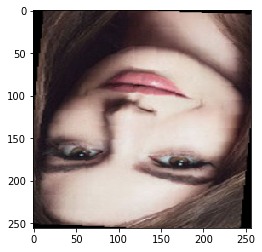

In [94]:
plt.imshow(np.transpose(s1[0],axes = (1,2,0)))
plt.savefig('aug1.png')
s1[1]

1

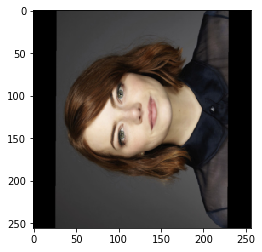

In [95]:
plt.imshow(np.transpose(s2[0],axes = (1,2,0)))
plt.savefig('aug2.png')
s2[1]

2

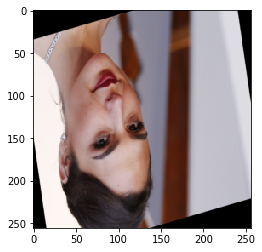

In [96]:
plt.imshow(np.transpose(s3[0],axes = (1,2,0)))
plt.savefig('aug3.png')
s3[1]

3

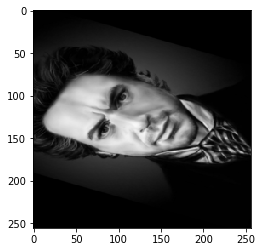

In [97]:
plt.imshow(np.transpose(s4[0],axes = (1,2,0)))
plt.savefig('aug4.png')
s4[1]

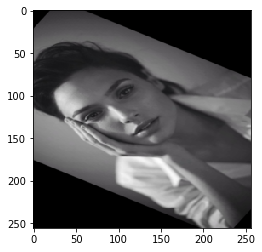

In [102]:
plt.imshow(np.transpose(s5[0],axes = (1,2,0)))


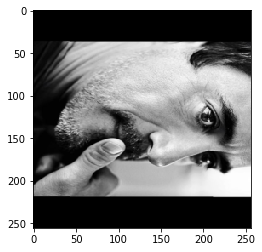

In [103]:
plt.imshow(np.transpose(s6[0],axes = (1,2,0)))


### iteration through data_loader

If you load the whole dataset, it is not recommended to interation through the whole loader, you can use break. Or you can skip this cell, it's just checking.

In [ ]:
for i_batch, sample_batched in enumerate(data_loaders['train']):
    print(i_batch, sample_batched[0].size(),sample_batched[1])
    break

##### check dataset has been loaded correctly

In [5]:
num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(data_loaders['train']):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        

        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 4
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 4
break minibatch for-loop


## Model

In [16]:
res18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
### some settings
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = len(image_datasets['train'].classes)

In [7]:
res18 = models.resnet18(pretrained = True)
#res50 = models.resnet50(pretrained = True)
#res101 = models.resnet101(pretrained = True)
#res152 = models.resnet152(pretrained = True)

In [8]:
for parameter in res18.parameters():
    parameter.requires_grad = False

In [117]:
res18.layer4[1].requires_grad = True
# res18.fc.requires_grad = True

In [118]:
res18.fc = nn.Sequential(
           nn.Linear(in_features=512, out_features=1000, bias=True),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=1000, out_features= num_classes, bias=True))

#### res50

In [ ]:
for parameter in res50.parameters():
    parameter.requires_grad = False

In [136]:
res50.fc = nn.Sequential(
           nn.Linear(in_features=512, out_features=1000, bias=True),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=1000, out_features= num_classes, bias=True))

#### res 101

In [137]:
for parameter in res101.parameters():
    parameter.requires_grad = False

In [138]:
res101.fc = nn.Sequential(
           nn.Linear(in_features=512, out_features=1000, bias=True),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=1000, out_features= num_classes, bias=True))

#### res 152

In [139]:
for parameter in res101.parameters():
    parameter.requires_grad = False

In [140]:
res101.fc = nn.Sequential(
           nn.Linear(in_features=512, out_features=1000, bias=True),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=1000, out_features= num_classes, bias=True))

## Train

In [9]:
res18 = res18.to(DEVICE)
#res50 = res50.to(DEVICE)
#res101 = res101.to(DEVICE)
#res152 = res152.to(DEVICE)
model = res18
optimizer = torch.optim.Adam(model.parameters())

In [10]:
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

  
    
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
 

In [11]:
def train(model, train_loader, test_loader, NUM_EPOCHS):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 5:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost
    


In [12]:
train_loader = data_loaders['train']
test_loader = data_loaders['test']

In [13]:
minibatch_cost, epoch_cost = train(res18, train_loader, test_loader, NUM_EPOCHS = 5)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Test accuracy: 33.33%


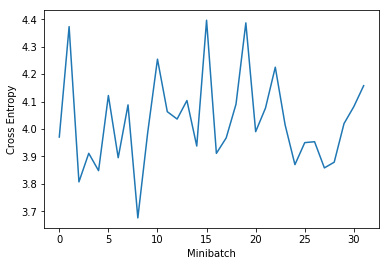

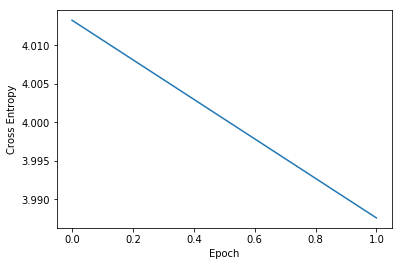

In [135]:
test_loader = data_loaders['test']
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))
    

plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [123]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    
    
train_loader = data_loaders['train']
num_epochs = 2
start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 5:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/002 | Batch 0000/0016 | Cost: 1.5326
Epoch: 001/002 | Batch 0005/0016 | Cost: 1.6382
Epoch: 001/002 | Batch 0010/0016 | Cost: 2.3447
Epoch: 001/002 | Batch 0015/0016 | Cost: 1.3892
Epoch: 001/002 | Train: 56.250% | Loss: 0.958
Time elapsed: 0.71 min
Epoch: 002/002 | Batch 0000/0016 | Cost: 1.2921
Epoch: 002/002 | Batch 0005/0016 | Cost: 1.1001
Epoch: 002/002 | Batch 0010/0016 | Cost: 1.0125
Epoch: 002/002 | Batch 0015/0016 | Cost: 0.5649
Epoch: 002/002 | Train: 70.312% | Loss: 0.846
Time elapsed: 1.47 min
Total Training Time: 1.47 min


In [124]:
test_loader = data_loaders['test']
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 33.33%


In [121]:
train_loader = data_loaders['train']
len(train_loader)

16